In [ ]:
data = pd.read_csv('BO_Training_Dataset.csv')
data.drop(['sku'], axis = 1,inplace=True)

In [24]:
cat = data.select_dtypes(include = ['object']).columns
for col in cat:
    data[col].replace({'No': 0, 'Yes': 1}, inplace=True)
    data[col] = data[col].astype(int)

In [25]:
data.perf_12_month_avg.replace({-99.0 : np.nan}, inplace = True)
data.perf_6_month_avg.replace({-99.0 : np.nan}, inplace = True)

In [10]:
skewed_right = ['national_inv' , 'in_transit_qty' , 'forecast_3_month','forecast_6_month',
                'forecast_9_month' , 'sales_1_month','sales_3_month',
                'sales_6_month','sales_9_month' ,
                'min_bank','pieces_past_due','local_bo_qty']

In [26]:
data_y = data['went_on_backorder']
X_train, X_test, y_train, y_test = train_test_split(data.drop(['went_on_backorder'], axis=1), data_y , random_state = 42 , stratify=data_y,test_size=0.20)

In [35]:
log_columns = []

for i in skewed_right:
    log_columns.append(X_train.columns.get_loc(i))

In [27]:
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X_train)
Xtrain = imp.transform(X_train)
Xtest = imp.transform(X_test)

In [38]:
def log_transform(a):
    sign = np.sign(a[log_columns])
    a[log_columns] =  np.log(1.0+abs(a[log_columns]))*sign
    return a

In [39]:
log_columns

[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15]

In [40]:
X_train_log = np.apply_along_axis(log_transform, 1, Xtrain)
X_test_log = np.apply_along_axis(log_transform, 1, Xtest)

In [41]:
sc = StandardScaler().fit(X_train_log)
X_train_log = sc.transform(X_train_log)
X_test_log = sc.transform(X_test_log)

## **Dummy**

In [19]:
dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(X_train_log, y_train)

DummyClassifier(strategy='uniform')

## **BRFC**

In [ ]:
bb = BalancedRandomForestClassifier(n_estimators=1000, n_jobs=-1).fit(X_train_log, y_train)

## **Fuzzy+BRFC**

In [45]:
fuzzy_params = {
    'national_inv': [0, 10, 100],
    'lead_time': [0, 2, 10],
    'in_transit_qty': [0, 5, 100],
    'forecast_3_month': [0, 10, 100],
    'forecast_6_month': [0, 10, 100],
    'forecast_9_month': [0, 10, 100],
    'sales_1_month': [0, 10, 100],
    'sales_3_month': [0, 10, 100],
    'sales_6_month': [0, 10, 100],
    'sales_9_month': [0, 10, 100],
    'min_bank': [0, 10, 100],
    'potential_issue': [0, 0.5, 1],
    'pieces_past_due': [0, 5, 50],
    'perf_6_month_avg': [0, 0.5, 1],
    'perf_12_month_avg': [0, 0.5, 1],
    'local_bo_qty': [0, 5, 50],
    'deck_risk': [0, 0.5, 1],
    'oe_constraint': [0, 0.5, 1],
    'ppap_risk': [0, 0.5, 1],
    'stop_auto_buy': [0, 0.5, 1],
    'rev_stop': [0, 0.5, 1]
}

def apply_fuzzy_logic(data, fuzzy_params):
    fuzzy_inputs = []
    for i, (column, params) in enumerate(fuzzy_params.items()):
        fuzzy_membership = fuzz.trimf(data[:, i], params)
        fuzzy_inputs.append(fuzzy_membership)
    fuzzy_inputs_2D = [fuzzy_membership.reshape(-1, 1) for fuzzy_membership in fuzzy_inputs]
    return np.concatenate(fuzzy_inputs_2D, axis=1)

X_train_fuzzy = apply_fuzzy_logic(X_train_log, fuzzy_params)

bb_fuzzy = BalancedBaggingClassifier(n_estimators=1000, n_jobs=-1).fit(X_train_fuzzy, y_train)

## **VAE + BRFC**

In [46]:
input_dim = X_train_log.shape[1]
latent_dim = 13

input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation='relu')(input_layer)
encoded = Dense(latent_dim, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

vae = Model(input_layer, decoded)

vae.compile(optimizer='adam', loss='mse')

vae.fit(X_train_log, X_train_log, epochs=10, batch_size=32, shuffle=True, validation_split=0.2)

encoder = Model(input_layer, encoded)
encoded_X_train = encoder.predict(X_train_log)

combined_X_train = np.concatenate([X_train_log, encoded_X_train], axis=1)

bb_autoencoder = BalancedBaggingClassifier(n_estimators=1000, n_jobs=-1).fit(combined_X_train, y_train)

Epoch 1/10
20972/20972 [==============================] - 59s 3ms/step - loss: 0.0372 - val_loss: 0.0090
Epoch 2/10
20972/20972 [==============================] - 61s 3ms/step - loss: 0.0094 - val_loss: 0.0065
Epoch 3/10
20972/20972 [==============================] - 59s 3ms/step - loss: 0.0075 - val_loss: 0.0057
Epoch 4/10
20972/20972 [==============================] - 60s 3ms/step - loss: 0.0066 - val_loss: 0.0053
Epoch 5/10
20972/20972 [==============================] - 60s 3ms/step - loss: 0.0059 - val_loss: 0.0042
Epoch 6/10
20972/20972 [==============================] - 63s 3ms/step - loss: 0.0053 - val_loss: 0.0050
Epoch 7/10
20972/20972 [==============================] - 59s 3ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 8/10
20972/20972 [==============================] - 59s 3ms/step - loss: 0.0048 - val_loss: 0.0050
Epoch 9/10
20972/20972 [==============================] - 56s 3ms/step - loss: 0.0045 - val_loss: 0.0049
Epoch 10/10
26215/26215 [==============================

In [47]:
encoded_X_test = encoder.predict(X_test_log)
combined_X_test = np.concatenate([X_test_log, encoded_X_test], axis=1)

6554/6554 [==============================] - 11s 2ms/step


## **MLP**

In [48]:
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

mlp_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

mlp_model.fit(X_train_log, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
20972/20972 [==============================] - 66s 3ms/step - loss: 0.0347 - accuracy: 0.9914 - val_loss: 0.0334 - val_accuracy: 0.9914
Epoch 2/10
20972/20972 [==============================] - 65s 3ms/step - loss: 0.0327 - accuracy: 0.9915 - val_loss: 0.0327 - val_accuracy: 0.9914
Epoch 3/10
20972/20972 [==============================] - 61s 3ms/step - loss: 0.0327 - accuracy: 0.9915 - val_loss: 0.0332 - val_accuracy: 0.9913
Epoch 4/10
20972/20972 [==============================] - 63s 3ms/step - loss: 0.0324 - accuracy: 0.9916 - val_loss: 0.0325 - val_accuracy: 0.9913
Epoch 5/10
20972/20972 [==============================] - 71s 3ms/step - loss: 0.0324 - accuracy: 0.9915 - val_loss: 0.0327 - val_accuracy: 0.9913
Epoch 6/10
20972/20972 [==============================] - 65s 3ms/step - loss: 0.0323 - accuracy: 0.9915 - val_loss: 0.0326 - val_accuracy: 0.9913
Epoch 7/10
20972/20972 [==============================] - 66s 3ms/step - loss: 0.0322 - accuracy: 0.9916 - val_loss: 0

In [49]:
dummy_preds_proba = dummy_clf.predict_proba(X_test_log)[:, 1]
bb_preds_proba = bb.predict_proba(X_test_log)[:, 1]
bb_fuzzy_preds_proba = bb_fuzzy.predict_proba(X_test_log)[:, 1]
bb_autoencoder_preds_proba = bb_autoencoder.predict_proba(combined_X_test)[:, 1]
mlp_preds_proba = mlp_model.predict(X_test_log)

fpr_dummy, tpr_dummy, _ = roc_curve(y_test, dummy_preds_proba)
fpr_bb, tpr_bb, _ = roc_curve(y_test, bb_preds_proba)
fpr_bb_fuzzy, tpr_bb_fuzzy, _ = roc_curve(y_test, bb_fuzzy_preds_proba)
fpr_bb_autoencoder, tpr_bb_autoencoder, _ = roc_curve(y_test, bb_autoencoder_preds_proba)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_preds_proba)

auc_dummy = auc(fpr_dummy, tpr_dummy)
auc_bb = auc(fpr_bb, tpr_bb)
auc_bb_fuzzy = auc(fpr_bb_fuzzy, tpr_bb_fuzzy)
auc_bb_autoencoder = auc(fpr_bb_autoencoder, tpr_bb_autoencoder)
auc_mlp = auc(fpr_mlp, tpr_mlp)

6554/6554 [==============================] - 11s 2ms/step


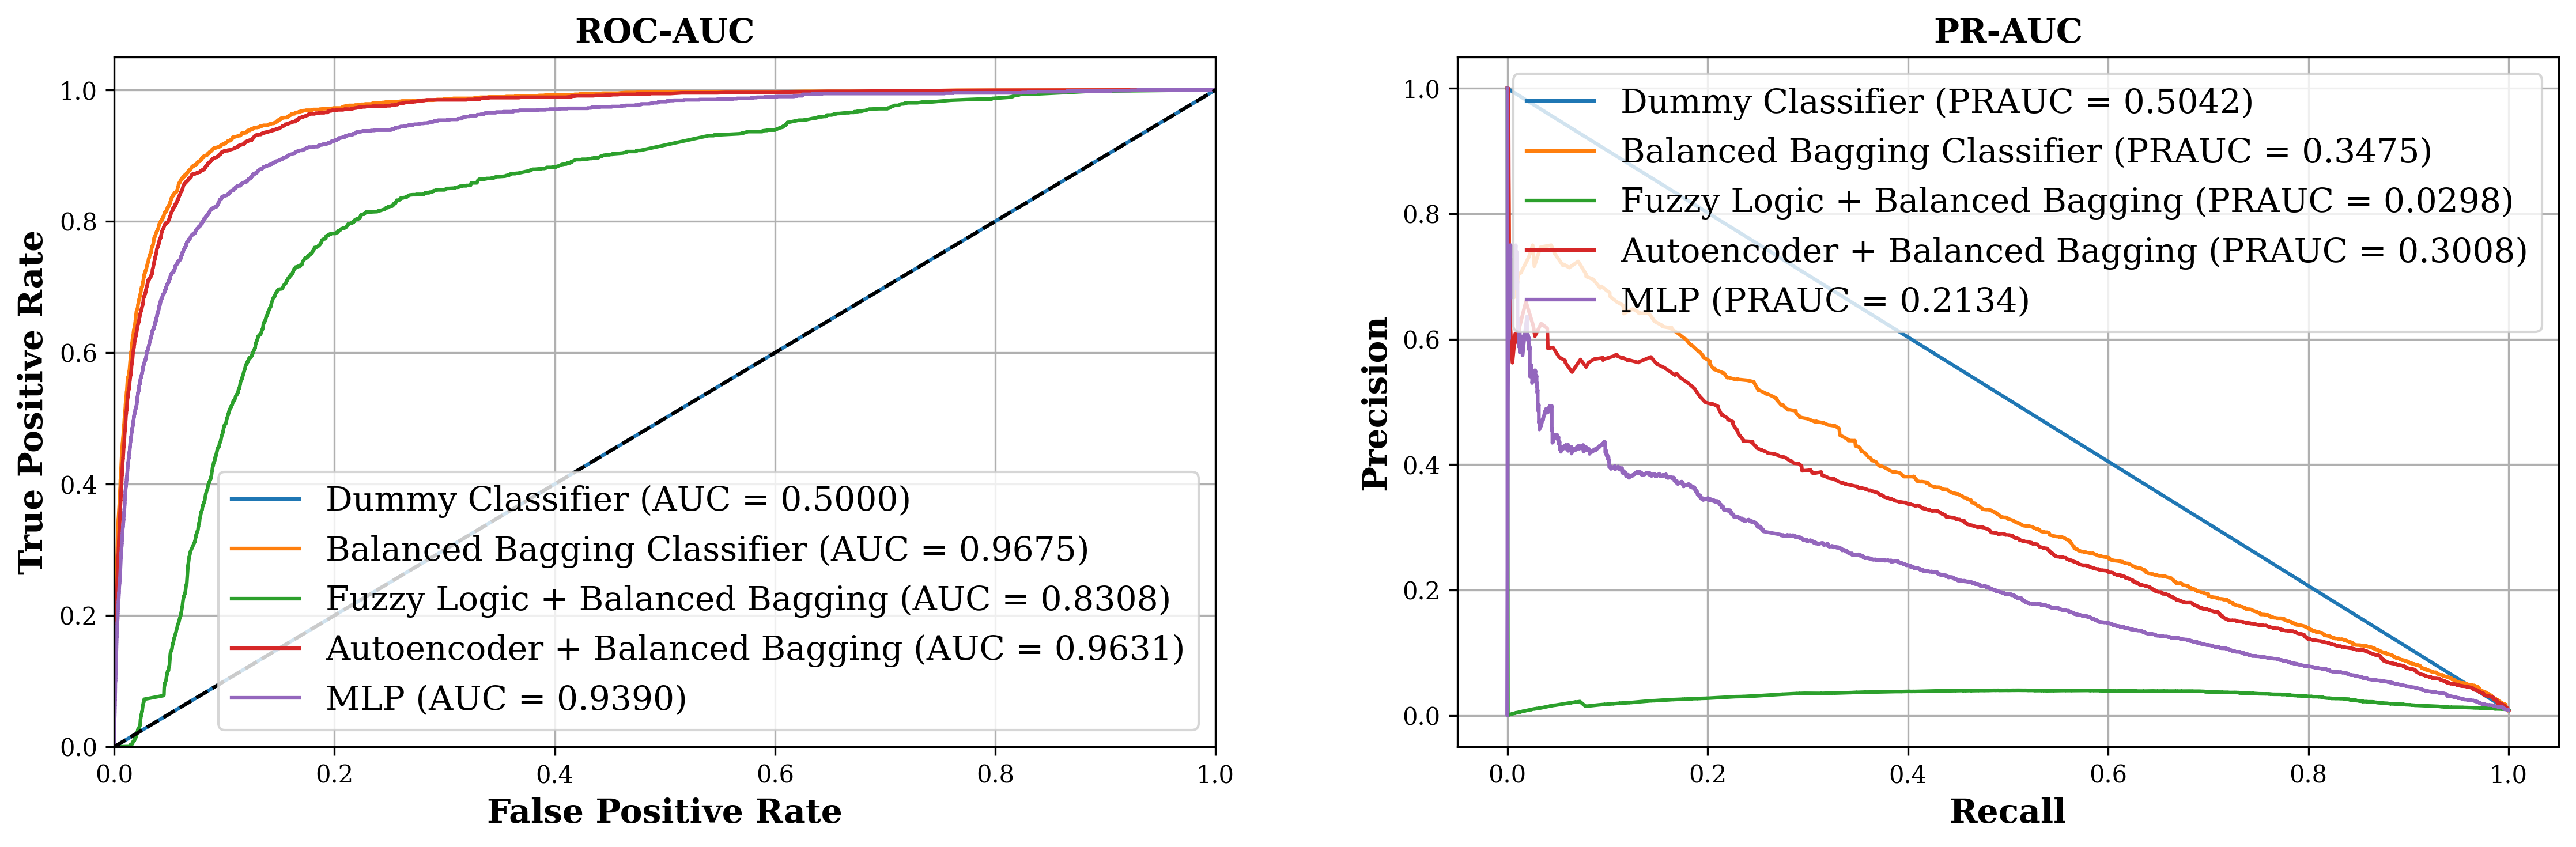

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=300)
axes[0].plot(fpr_dummy, tpr_dummy, label=f'Dummy Classifier (AUC = {auc_dummy:.4f})')
axes[0].plot(fpr_bb, tpr_bb, label=f'Balanced Bagging Classifier (AUC = {auc_bb:.4f})')
axes[0].plot(fpr_bb_fuzzy, tpr_bb_fuzzy, label=f'Fuzzy Logic + Balanced Bagging (AUC = {auc_bb_fuzzy:.4f})')
axes[0].plot(fpr_bb_autoencoder, tpr_bb_autoencoder, label=f'Autoencoder + Balanced Bagging (AUC = {auc_bb_autoencoder:.4f})')
axes[0].plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {auc_mlp:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
axes[0].legend(loc='best', fontsize=14)
axes[0].set_title('ROC-AUC', fontsize=14, fontweight='bold')
axes[0].grid()

preauc_dummy, recall_dummy, _ = precision_recall_curve(y_test, dummy_preds_proba)
auc_dummy = auc(recall_dummy, preauc_dummy)
preauc_bb, recall_bb, _ = precision_recall_curve(y_test, bb_preds_proba)
auc_bb = auc(recall_bb, preauc_bb)
preauc_bb_fuzzy, recall_bb_fuzzy, _ = precision_recall_curve(y_test, bb_fuzzy_preds_proba)
auc_fuzzy = auc(recall_bb_fuzzy, preauc_bb_fuzzy)
preauc_bb_autoencoder, recall_bb_autoencoder, _ = precision_recall_curve(y_test, bb_autoencoder_preds_proba)
auc_bbauto = auc(recall_bb_autoencoder, preauc_bb_autoencoder)
preauc_mlp, recall_mlp, _ = precision_recall_curve(y_test, mlp_preds_proba)
auc_mlp = auc(recall_mlp, preauc_mlp)

axes[1].plot(recall_dummy, preauc_dummy, label=f'Dummy Classifier (PRAUC = {auc_dummy:.4f})')
axes[1].plot(recall_bb, preauc_bb, label=f'Balanced Bagging Classifier (PRAUC = {auc_bb:.4f})')
axes[1].plot(recall_bb_fuzzy, preauc_bb_fuzzy, label=f'Fuzzy Logic + Balanced Bagging (PRAUC = {auc_fuzzy:.4f})')
axes[1].plot(recall_bb_autoencoder, preauc_bb_autoencoder, label=f'Autoencoder + Balanced Bagging (PRAUC = {auc_bbauto:.4f})')
axes[1].plot(recall_mlp, preauc_mlp, label=f'MLP (PRAUC = {auc_mlp:.4f})')
axes[1].set_xlabel('Recall', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Precision', fontsize=14, fontweight='bold')
axes[1].legend(loc='best', fontsize=14)
axes[1].set_title('PR-AUC', fontsize=14, fontweight='bold')
axes[1].grid()

plt.tight_layout()
plt.show()

In [54]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix

y_pred = bb.predict(X_test_log)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

from sklearn.metrics import f1_score
# Calculate macro-average F1 score
macro_f1 = f1_score(y_test, y_pred, average='macro')
print("Macro-average F1 Score:", macro_f1)

f2_score = fbeta_score(y_test, y_pred, beta=2)
print("F2 Score:", f2_score)

from sklearn.metrics import matthews_corrcoef
mcc_score = matthews_corrcoef(y_test, y_pred)
print("Matthews Correlation Coefficient (MCC):", mcc_score)

from sklearn.metrics import cohen_kappa_score
kappa_score = cohen_kappa_score(y_test, y_pred)
print("Cohen’s Kappa:", kappa_score)

from sklearn.metrics import brier_score_loss
brier_score = brier_score_loss(y_test, y_pred)
print("Brier Score:", brier_score)

Confusion Matrix:
[[190462  17473]
 [   177   1603]]
F1 Score: 0.15372075182201766
Macro-average F1 Score: 0.5547189416980396
F2 Score: 0.30596274240342036
Matthews Correlation Coefficient (MCC): 0.260493446140484
Cohen’s Kappa: 0.14037366421707909
Brier Score: 0.08416183868583554


In [118]:
# Define misclassification costs
false_negative_cost = 100  # Cost of misclassifying a backorder item as non-backorder
false_positive_cost = 10   # Cost of misclassifying a non-backorder item as backorder

misclassification_cost = (conf_matrix[1, 0] * false_negative_cost) + (conf_matrix[0, 1] * false_positive_cost)

print("Misclassification Cost:", misclassification_cost)

Misclassification Cost: 192430


In [111]:
def calculate_profit(row, costs, revenue):
    inventory_level = row['national_inv'] + row['in_transit_qty']
    backorders = row['went_on_backorder']
    lead_time = row['lead_time']
    potential_issue = row['potential_issue']
    deck_risk = row['deck_risk']

    holding_cost = costs['holding']
    backorder_cost = costs['backorder']
    lead_time_cost = costs['lead_time']
    potential_issue_cost = costs['potential_issue']
    deck_risk_cost = costs['deck_risk']

    if backorders == 0:
        profit = revenue - (holding_cost * inventory_level) - (lead_time_cost * lead_time) - (potential_issue_cost * potential_issue) - (deck_risk_cost * deck_risk)
    else:
        profit = revenue - (holding_cost * inventory_level) - (backorder_cost * backorders) - (lead_time_cost * lead_time) - (potential_issue_cost * potential_issue) - (deck_risk_cost * deck_risk)
    return profit

df_predictions = pd.DataFrame(y_pred, columns=['went_on_backorder'])

df_X_test = pd.DataFrame(X_test_log, columns=['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
                                              'forecast_6_month', 'forecast_9_month', 'sales_1_month', 'sales_3_month',
                                              'sales_6_month', 'sales_9_month', 'min_bank', 'potential_issue',
                                              'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg', 'local_bo_qty',
                                              'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop'])

df_combined = pd.concat([df_X_test, df_predictions], axis=1)

costs = {
    'holding': 2,
    'backorder': 50,
    'lead_time': 20,
    'potential_issue': 10,
    'deck_risk': 0.5
}

df_combined['revenue'] = (df_combined['sales_1_month'] + df_combined['sales_3_month'] + df_combined['sales_6_month'] + df_combined['sales_9_month']).sum()
df_combined['profit'] = df_combined.apply(lambda row: calculate_profit(row, costs, row['revenue']), axis=1)

print(df_combined['profit'].mean())


2793.3497353152065
